# Insurance Fraud Claims Detection

This notebook summarizes the steps I did for building the model and the information I need to put our model in production

**Premise: Setting the seed**

Because now we have to move the model in production for reproducibility it's important to **set the seed**

## Libraries and Environments

In [1]:
# Read the data
import pandas as pd
import numpy as np

# Data Science
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix

# Model Deployment
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

#Utils
import os

# Set notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.simplefilter(action='ignore')

In [27]:
raw = '../data/raw/insurance_claims.csv'
interim = '../data/interim/'
processed= '../data/processed/'
models= '../models/'

## Data Preparation

In [3]:
# load dataset
data = pd.read_csv(raw)
print(data.shape)
data.head()

(1000, 40)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


## Variable settings

In [4]:
drop = ['policy_number', 'policy_bind_date', 'policy_state', 'policy_csl', 
        'insured_zip', 'insured_occupation', 'incident_date', 
        'insured_education_level', 'insured_relationship', 'injury_claim', 'property_claim', 'vehicle_claim', 
        'incident_state', 'incident_city', 'incident_location', 'auto_model', 'auto_make', 'auto_year', '_c39']

data.drop(drop, axis=1, inplace=True)
data.rename(columns={"capital-gains": "capital_gains", "capital-loss": "capital_loss"}, inplace=True)

In [5]:
# general
target = 'fraud_reported'
predictors = [col for col in data.columns if col not in drop and col != target]

## Feature engineering

### Engineer Missing

In [7]:
# missing
missing_predictors = [col for col in data.select_dtypes(include='object').columns if any(data[col].str.contains('?', regex=False))]
missing_predictors

['collision_type', 'property_damage', 'police_report_available']

In [8]:
data[missing_predictors] = data[missing_predictors].replace('?', 'missing')

In [9]:
for var in missing_predictors:
    print(data[var].unique())

['Side Collision' 'missing' 'Rear Collision' 'Front Collision']
['YES' 'missing' 'NO']
['YES' 'missing' 'NO']


### Engineer Target

In [10]:
data[target].unique()

array(['Y', 'N'], dtype=object)

In [11]:
#Create the list of target labels
target_labels = set(data[target])
#Create encoding dictionary
target_labels_dic = {label: index for index, label in enumerate(target_labels, 0)}
#Encode the data
data[target] = data[target].map(target_labels_dic).astype('category')

print(data[target].cat.categories)

Int64Index([0, 1], dtype='int64')


### Engineer Numerical Variables

I divided them in: 

- Discrete variables
- Continuous variables


In [12]:
# numerical
numerical_predictors = [col for col in predictors if data[col].dtypes != 'object']
discrete_predictors = [col for col in numerical_predictors if len(data[col].unique()) < 30]
continuous_predictors = [col for col in numerical_predictors if col not in discrete_predictors]

print(numerical_predictors)
print('\n', discrete_predictors)
print('\n', continuous_predictors)

['months_as_customer', 'age', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'capital_gains', 'capital_loss', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'total_claim_amount']

 ['policy_deductable', 'umbrella_limit', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses']

 ['months_as_customer', 'age', 'policy_annual_premium', 'capital_gains', 'capital_loss', 'total_claim_amount']


#### Discrete Variables

In [13]:
data[discrete_predictors].head()

,policy_deductable,umbrella_limit,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses
0,1000,0,5,1,1,2
1,2000,5000000,8,1,0,0
2,2000,5000000,7,3,2,3
3,2000,6000000,5,1,1,2
4,1000,6000000,20,1,0,1


In [14]:
#umbrella
data = data[data['umbrella_limit']>=0]
print('\n', data['umbrella_limit'].unique())
        
#policy_deductable
bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']
new_variable_name = "_".join(['policy_deductable', 'groups'])
data[new_variable_name] = pd.cut(data['policy_deductable'], bins = bins, labels = bin_labels)
data.drop('policy_deductable', axis=1, inplace=True)
print('\n', data[new_variable_name].unique())


 [       0  5000000  6000000  4000000  3000000  8000000  7000000  9000000
 10000000  2000000]

 [501-1000, 1501-2000, 0-500]
Categories (3, object): [0-500 < 501-1000 < 1501-2000]


#### Continuous variables

In [15]:
data[continuous_predictors].head()

,months_as_customer,age,policy_annual_premium,capital_gains,capital_loss,total_claim_amount
0,328,48,1406.91,53300,0,71610
1,228,42,1197.22,0,0,5070
2,134,29,1413.14,35100,0,34650
3,256,41,1415.74,48900,-62400,63400
4,228,44,1583.91,66000,-46000,6500


In [16]:
#age
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
new_variable_name = "_".join(['age', 'groups'])
data[new_variable_name] = pd.cut(data['age'], bins = bins, labels = bin_labels, include_lowest = True)
data.drop('age', axis=1, inplace=True)
print('\n', data[new_variable_name].unique())

#policy_annual_premium
bins = list(np.linspace(0,2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']
new_variable_name = "_".join(['policy_annual_premium', 'groups'])
data[new_variable_name] = pd.cut(data['policy_annual_premium'], bins = bins, labels=bin_labels)
data.drop('policy_annual_premium', axis=1, inplace=True)
print('\n', data[new_variable_name].unique())

#month_as_customer
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']
new_variable_name = "_".join(['months_as_customer', 'groups'])
data[new_variable_name] = pd.cut(data['months_as_customer'], bins = 10, labels = bin_labels, include_lowest= True)
data.drop(['months_as_customer'], axis=1, inplace=True)
print('\n', data[new_variable_name].unique())


 [46-50, 41-45, 26-30, 36-40, 31-35, 61-65, 21-25, 56-60, 51-55, 15-20]
Categories (10, object): [15-20 < 21-25 < 26-30 < 31-35 ... 46-50 < 51-55 < 56-60 < 61-65]

 [medium, high, low, very high, very low]
Categories (5, object): [very low < low < medium < high < very high]

 [301-350, 201-250, 101-150, 251-300, 151-200, 0-50, 451-500, 51-100, 351-400, 401-450]
Categories (10, object): [0-50 < 51-100 < 101-150 < 151-200 ... 301-350 < 351-400 < 401-450 < 451-500]


### Engineer Categorical variables

In [17]:
# non numerical
categorical_predictors = [col for col in data.columns if data[col].dtypes != 'int' and col != target]
ordinal_predictors = ['incident_severity', 'policy_annual_premium_groups', 'policy_deductable_groups']
nominal_predictors = [col for col in categorical_predictors if col not in ordinal_predictors]

print(categorical_predictors)
print('\n', ordinal_predictors)
print('\n', nominal_predictors)

['insured_sex', 'insured_hobbies', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'property_damage', 'police_report_available', 'policy_deductable_groups', 'age_groups', 'policy_annual_premium_groups', 'months_as_customer_groups']

 ['incident_severity', 'policy_annual_premium_groups', 'policy_deductable_groups']

 ['insured_sex', 'insured_hobbies', 'incident_type', 'collision_type', 'authorities_contacted', 'property_damage', 'police_report_available', 'age_groups', 'months_as_customer_groups']


#### Nominal

In [18]:
#insured_hobbies
replace_labels = [label for label in data['insured_hobbies'].unique() if label not in ['chess', 'cross-fit']]
data['insured_hobbies'] = data['insured_hobbies'].replace(replace_labels, 'others')
#Dummies
data = pd.get_dummies(data, columns=nominal_predictors)

#### Ordinal

In [19]:
ord_var_labels = {col: list(data[col].unique()) for col in ordinal_predictors}
categories = []
#'incident_severity'
categories.append(pd.Categorical(data[ordinal_predictors]['incident_severity'],
                                  categories=['Trivial Damage',
                                              'Minor Damage',
                                              'Major Damage',
                                              'Total Loss'],
                                  ordered=True))

# 'policy_annual_premium_groups'
categories.append(pd.Categorical(data[ordinal_predictors]['policy_annual_premium_groups'],
                                          categories=['very low',
                                                  'low',
                                                  'medium',
                                                  'high',
                                                  'very high'],
                                          ordered=True))

#'policy_deductable_groups'
categories.append(pd.Categorical(data[ordinal_predictors]['policy_deductable_groups'],
                               categories=['0-500', '501-1000', '1001-1500', '1501-2000'],
                               ordered=True))

for variable, category in zip(ord_var_labels, categories):
    labels, unique = pd.factorize(category, sort=True)
    data[variable] = labels
    print(data[variable].unique())

[2 1 3 0]
[2 3 1 4 0]
[1 2 0]


In [20]:
data.head()

,umbrella_limit,capital_gains,capital_loss,incident_severity,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,fraud_reported,policy_deductable_groups,policy_annual_premium_groups,insured_sex_FEMALE,insured_sex_MALE,insured_hobbies_chess,insured_hobbies_cross-fit,insured_hobbies_others,incident_type_Multi-vehicle Collision,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,collision_type_Front Collision,collision_type_Rear Collision,collision_type_Side Collision,collision_type_missing,authorities_contacted_Ambulance,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police,property_damage_NO,property_damage_YES,property_damage_missing,police_report_available_NO,police_report_available_YES,police_report_available_missing,age_groups_15-20,age_groups_21-25,age_groups_26-30,age_groups_31-35,age_groups_36-40,age_groups_41-45,age_groups_46-50,age_groups_51-55,age_groups_56-60,age_groups_61-65,months_as_customer_groups_0-50,months_as_customer_groups_51-100,months_as_customer_groups_101-150,months_as_customer_groups_151-200,months_as_customer_groups_201-250,months_as_customer_groups_251-300,months_as_customer_groups_301-350,months_as_customer_groups_351-400,months_as_customer_groups_401-450,months_as_customer_groups_451-500
0,0,53300,0,2,5,1,1,2,71610,1,1,2,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,5000000,0,0,1,8,1,0,0,5070,1,2,2,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,5000000,35100,0,1,7,3,2,3,34650,0,2,2,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,6000000,48900,-62400,2,5,1,1,2,63400,1,2,2,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,6000000,66000,-46000,1,20,1,0,1,6500,0,1,3,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### Feature Scaling

In [21]:
predictors = [col for col in data.columns if col != 'fraud_reported']

# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(data[predictors]) 

# transform the train and test set
data[predictors] = scaler.transform(data[predictors])

In [22]:
data[predictors].shape, data['fraud_reported'].shape

((999, 55), (999,))

### Selected features

In [6]:
# load selected features
features = pd.read_csv(processed + 'selected_features.csv', names=['features'])
features = list(features['features'])

print('Number of features: ', len(features))
print('\n', sorted(features))

Number of features:  13

 ['bodily_injuries', 'capital_gains', 'capital_loss', 'incident_hour_of_the_day', 'incident_severity', 'insured_hobbies_chess', 'insured_hobbies_cross-fit', 'insured_hobbies_others', 'policy_annual_premium_groups', 'policy_deductable_groups', 'total_claim_amount', 'umbrella_limit', 'witnesses']


### Balancing

In [23]:
smote = SMOTE(random_state=9)
X, y = smote.fit_resample(data[features], data[target])

## Model Training: Random Forest

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=1) # ALWAYS set random seed for reproducibility!
X_train.shape, X_test.shape

((1203, 13), (301, 13))

In [25]:
print(y_train.value_counts()/len(y_train), '\n')

1    0.512053
0    0.487947
Name: fraud_reported, dtype: float64 



********************
**Model Assessment**
********************
score: 0.89

Classification report
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       165
           1       0.83      0.94      0.88       136

    accuracy                           0.89       301
   macro avg       0.89      0.89      0.89       301
weighted avg       0.89      0.89      0.89       301


Confusion Matrix


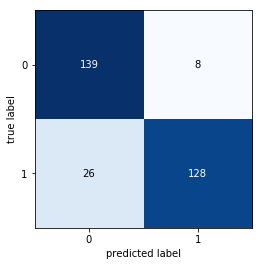

In [26]:
rfor = RandomForestClassifier(max_depth=25, min_samples_split=5, n_estimators=300,
                       random_state=8)

rfor.fit(X_train, y_train)
predictions = rfor.predict(X_test)

print("*"*20)
print("Model Assessment".center(20, '*'))
print("*"*20)

print('score: {}'.format(round(rfor.score(X_test, y_test), 2)))
print()

print('Classification report')
print(classification_report(y_test, predictions))

print()

print('Confusion Matrix')
conf_matrix = confusion_matrix(predictions, y_test)
plot_confusion_matrix(conf_matrix);

## Model Persistence: ONNX format

In [57]:
# Convert into ONNX format

initial_type = [('float_input', FloatTensorType([1, X_train.shape[1]]))]

onnx = skl2onnx.to_onnx(rfor, name='rf_champion', initial_types=initial_type)
with open(models + "rf_champion.onnx", "wb") as f:
    f.write(onnx.SerializeToString())

In [65]:
sess = rt.InferenceSession(models + "rf_champion.onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

pred_onnx = sess.run([label_name], {input_name: np.array([[1.00000000]])})[0]
print(pred_onnx)

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Unexpected input data type. Actual: (N11onnxruntime17PrimitiveDataTypeIdEE) , expected: (N11onnxruntime17PrimitiveDataTypeIfEE)

That is all for this notebook.

**Move on productionalizing this model for model deployment**.